In [1]:
from data_loader import load_data, load_data_sample
from models import LogisticLogOddsModel, XGBoostLogOddsModel
from explainers import SHAPExplainer
from util import printmd
import shap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import sklearn
import numpy as np

In [2]:
notebook_name = 'Compare Explanations of Log Odds with SHAP'
printmd(f'# {notebook_name}')
SHAPExplainer.group_identifier = notebook_name
%matplotlib inline

# Compare Explanations of Log Odds with SHAP

In [3]:
X, y, display_data = load_data()
feature_names = list(X.columns)
linear_model = LogisticLogOddsModel()
linear_model.load_or_train(X, y)
tree_based_model = XGBoostLogOddsModel()
tree_based_model.load_or_train(X, y)

Loaded model: models/Logistic.model
Loaded model: models/XGBoost.model


In [4]:
X_sample, y_sample, display_data_sample = load_data_sample()

In [5]:
linear_model_explainer = SHAPExplainer(linear_model, 'Linear')
linear_model_explainer.load_or_generate(X_sample, display_data_sample)

divide by zero encountered in log
divide by zero encountered in log
Permutation explainer: 1001it [00:35, 23.24it/s]                         

Finished generating: models/Compare Explanations of Log Odds with SHAP.Linear.exp (0:00:35.099531)


In [6]:
tree_based_model_explainer = SHAPExplainer(tree_based_model, 'Tree-based')
tree_based_model_explainer.load_or_generate(X_sample, display_data_sample)

Permutation explainer: 1001it [00:33, 21.69it/s]                          


Finished generating: models/Compare Explanations of Log Odds with SHAP.Tree-based.exp (0:00:34.058996)


In [7]:
explainers = [linear_model_explainer, tree_based_model_explainer]
last_explainer = explainers[-1]

Attention, some SHAP values aren't finite numbers, remove them first:

In [8]:
# find and remove instances with non-finite SHAP-values
include_ids = set(range(0, len(y_sample)))
for explainer in explainers:
    df = pd.DataFrame(explainer.shap_values.values)
    explainer_include = np.isfinite(df).all(1)
    for exclude_id in explainer_include[explainer_include == False].index:
        printmd(f'##### {explainer.identifier}/#{exclude_id} has non-finite SHAP-values:')
        print(pd.DataFrame(explainer.shap_values[exclude_id].display_data, index=feature_names))
        print(pd.DataFrame(explainer.shap_values[exclude_id].values, index=feature_names))
    explainer_include_ids = set(explainer_include[explainer_include == True].index.to_list())
    include_ids = include_ids & explainer_include_ids
for explainer in explainers:
    explainer.shap_values = explainer.shap_values[list(include_ids)]

##### Linear/#139 has non-finite SHAP-values:

                                  0
Age                              41
Workclass              Self-emp-inc
Education-Num                    16
Marital Status   Married-civ-spouse
Occupation           Prof-specialty
Relationship                Husband
Race                          White
Sex                            Male
Capital Gain                  99999
Capital Loss                      0
Hours per week                   70
Country               United-States
                        0
Age              0.076346
Workclass       -0.025136
Education-Num         inf
Marital Status   0.098984
Occupation       0.058504
Relationship     0.659222
Race             0.039907
Sex              0.175154
Capital Gain    32.600853
Capital Loss         -inf
Hours per week        inf
Country          0.025295


## Scatter plots
They are generalizations of the partial dependence plots.

With the parameter color, we instruct SHAP to pick the feature that has the biggest interaction effects with the explained feature and to colour the observations according to its' shapeley values.

In [9]:
def scatter_plot(feature_name):
    printmd(f'### {feature_name}')
    for explainer in explainers:
        shap.plots.scatter(explainer.shap_values[:, feature_name], color=explainer.shap_values, title=explainer.identifier)

### Age

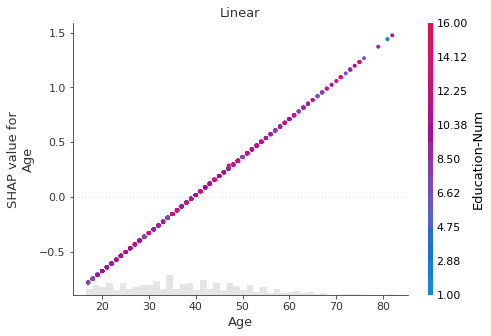

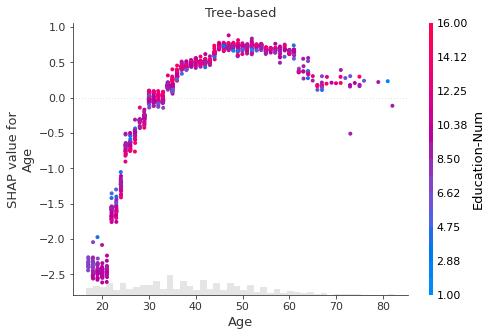

In [10]:
scatter_plot('Age')

### Workclass

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


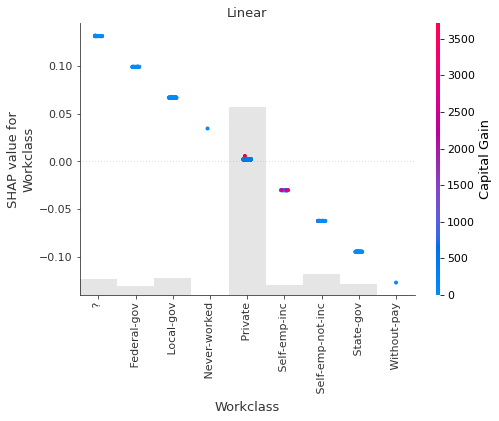

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


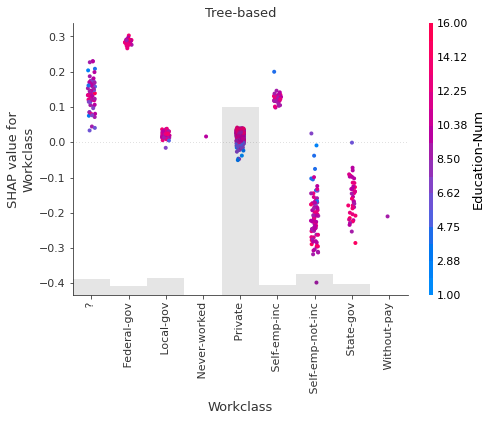

In [11]:
scatter_plot('Workclass')

### Education-Num

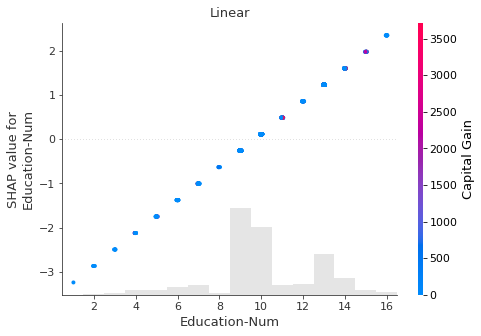

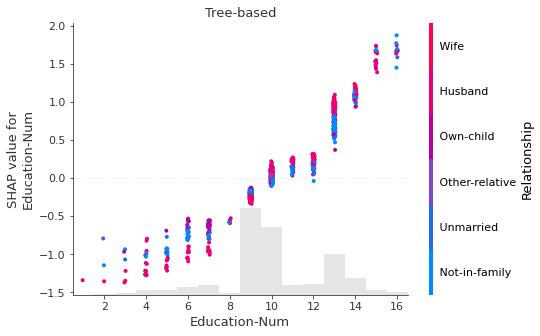

In [12]:
scatter_plot('Education-Num')

### Marital Status

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


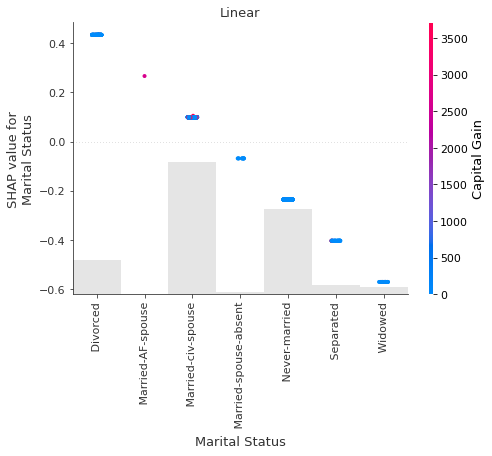

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


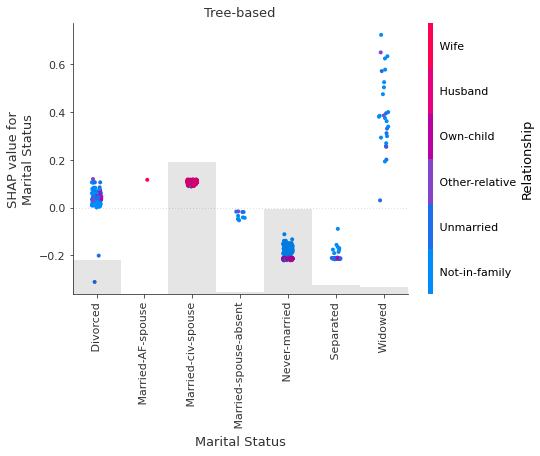

In [13]:
scatter_plot('Marital Status')

### Occupation

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


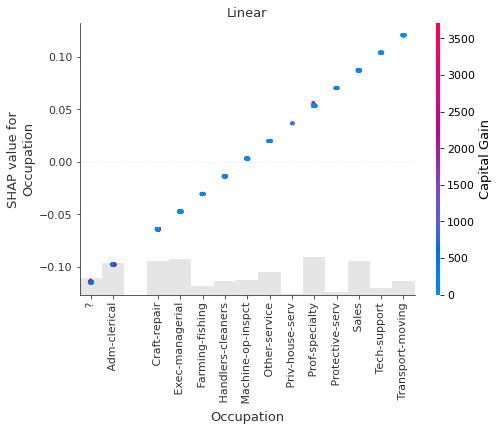

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


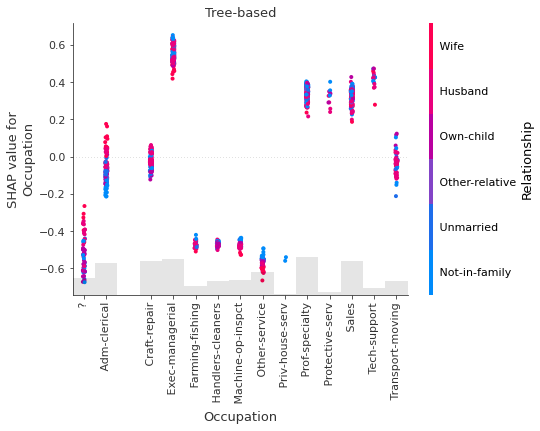

In [14]:
scatter_plot('Occupation')

### Relationship

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


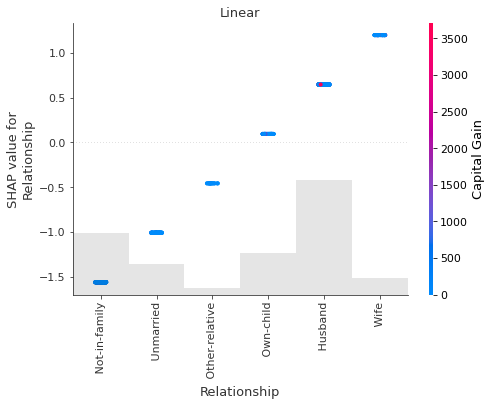

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


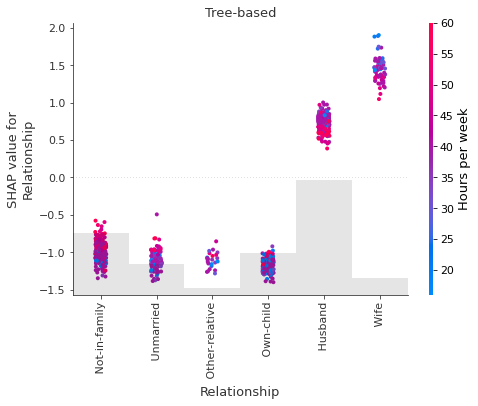

In [15]:
scatter_plot('Relationship')

### Race

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


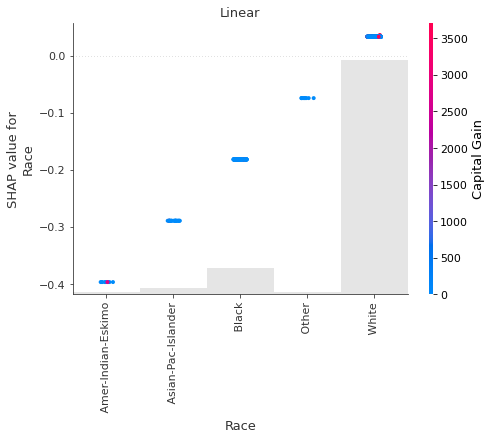

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


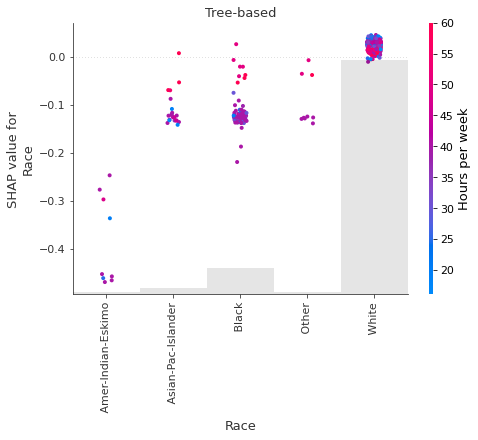

In [16]:
scatter_plot('Race')

### Sex

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


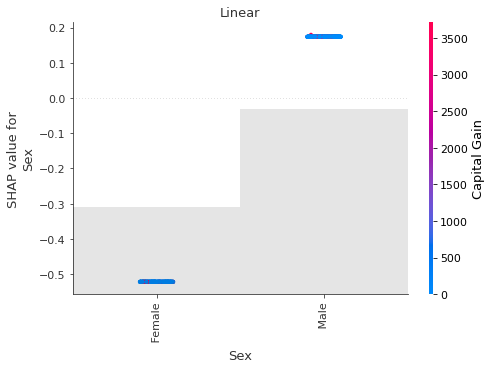

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


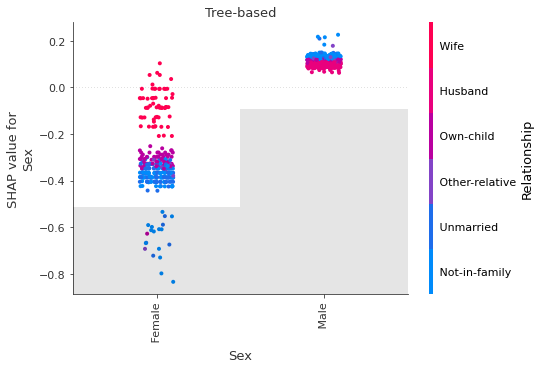

In [17]:
scatter_plot('Sex')

### Capital Gain

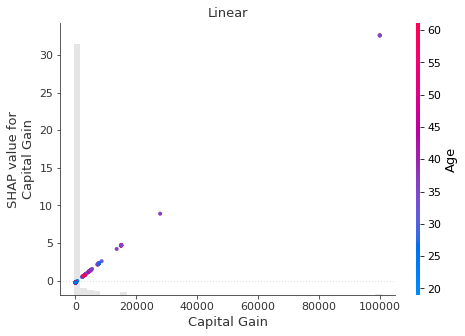

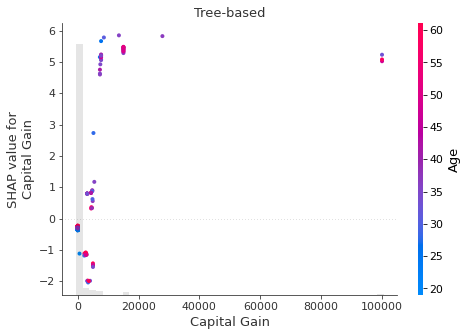

In [18]:
scatter_plot('Capital Gain')

### Capital Loss

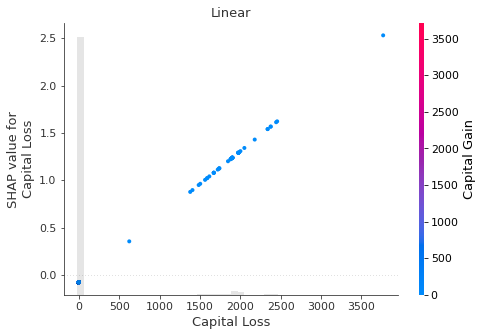

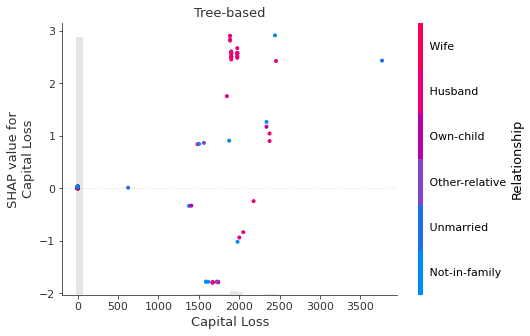

In [19]:
scatter_plot('Capital Loss')

### Hours per week

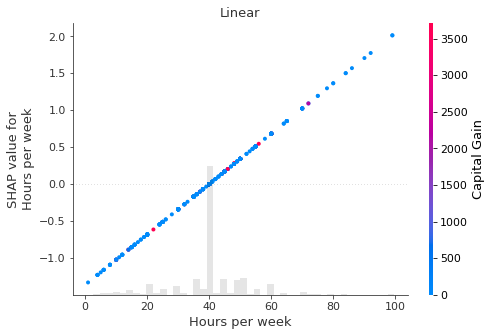

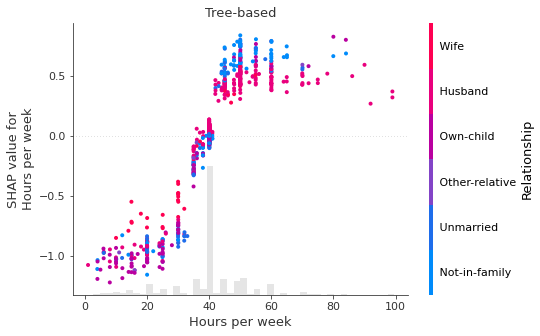

In [20]:
scatter_plot('Hours per week')

### Country

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


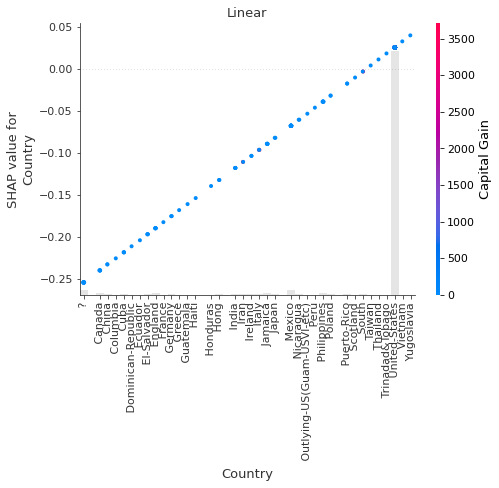

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


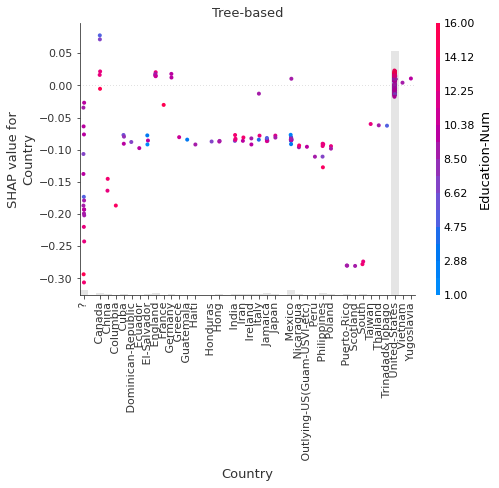

In [21]:
scatter_plot('Country')

## Bar plots
> By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

### Linear

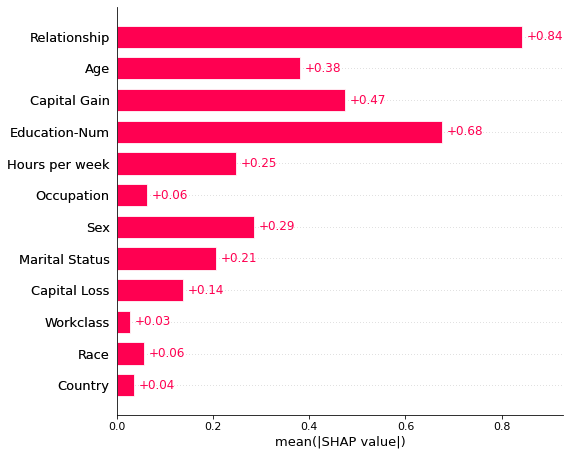

### Tree-based

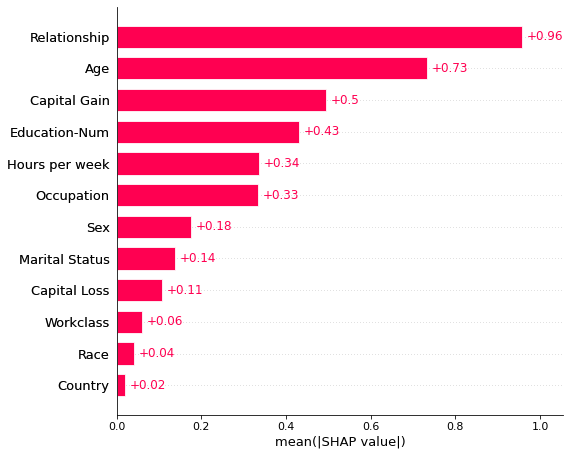

In [22]:
order = np.argsort(-last_explainer.shap_values.abs.mean(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.bar(explainer.shap_values, max_display=len(feature_names), order=order)

> But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrewuent but high magnitude effects.

### Linear

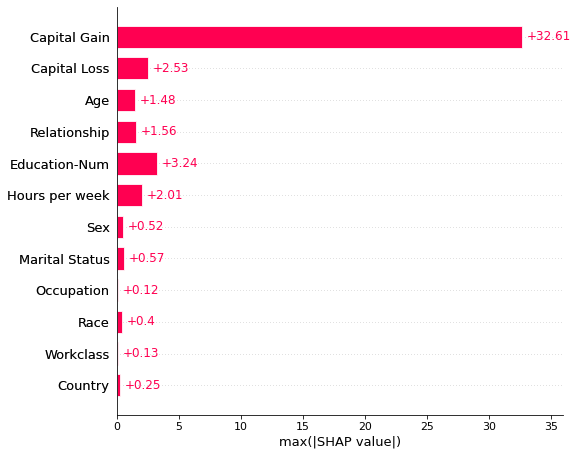

### Tree-based

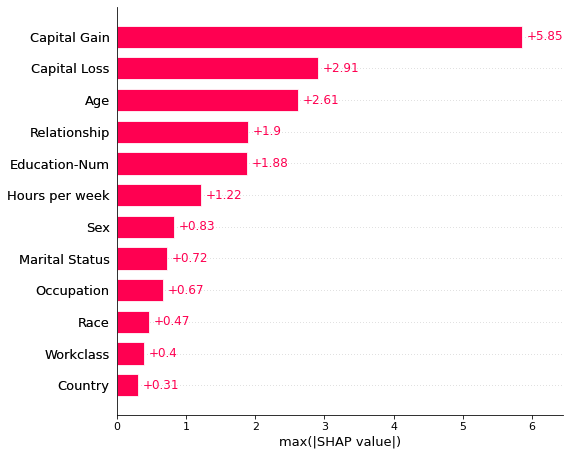

In [23]:
order = np.argsort(-last_explainer.shap_values.abs.max(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.bar(explainer.shap_values.abs.max(0), max_display=len(feature_names), order=order)

We can also compare feature importance for subsets separately, like for men and women:

### Linear

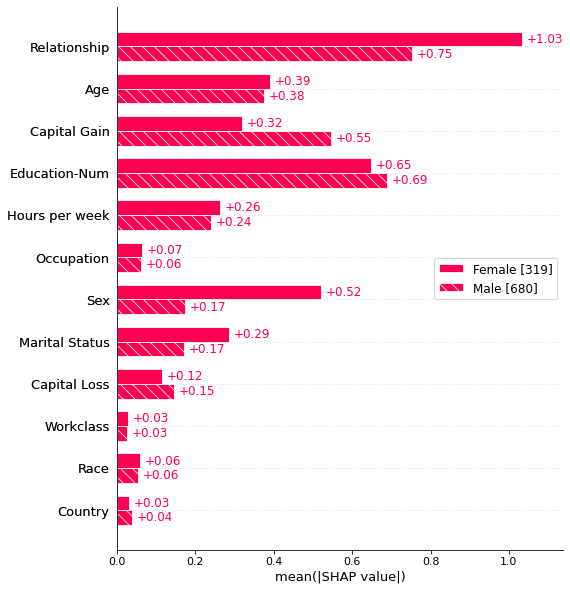

### Tree-based

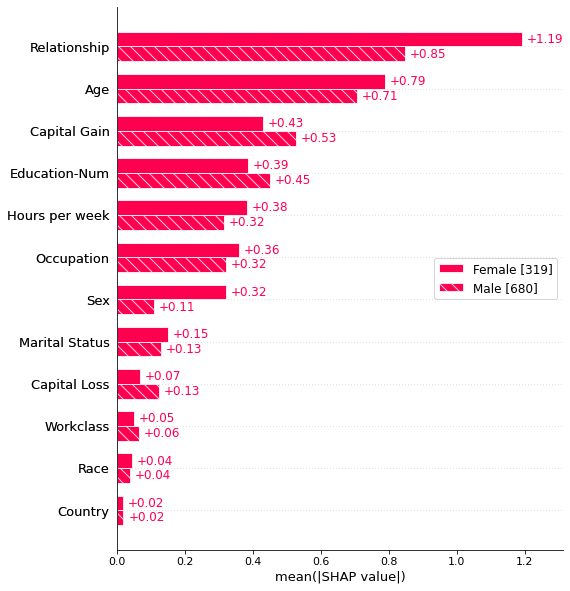

In [24]:
order = np.argsort(-last_explainer.shap_values.abs.mean(0).values)
sex = pd.DataFrame(last_explainer.shap_values.display_data, columns=feature_names)['Sex'].str.strip().to_list()
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.bar(explainer.shap_values.cohorts(sex).abs.mean(0), max_display=len(feature_names), order=order)

## Beeswarm plots
They show the Shapeley value distribution per feature.
> If we are willing to deal with a bit more complexity we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

### Linear

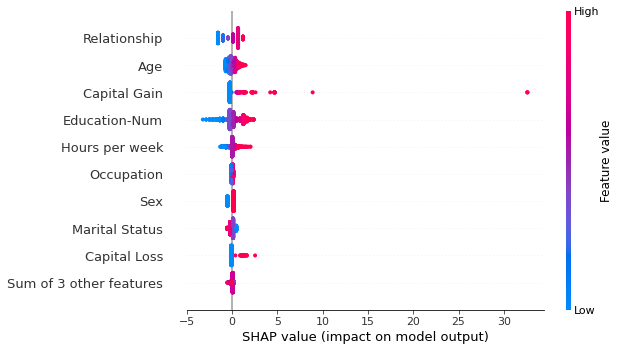

### Tree-based

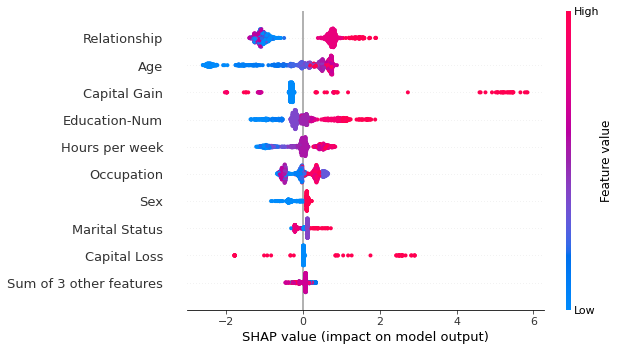

In [25]:
order = np.argsort(-last_explainer.shap_values.abs.mean(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.beeswarm(explainer.shap_values, order=order)

> By taking the absolute value and using a solid color we get a compromise between the complexity of the bar plot and the full beeswarm plot. Note that the bar plots above are just summary statistics from the values shown in the beeswarm plots below.

### Linear

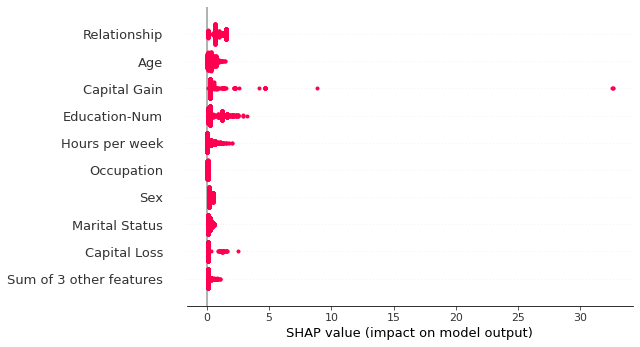

### Tree-based

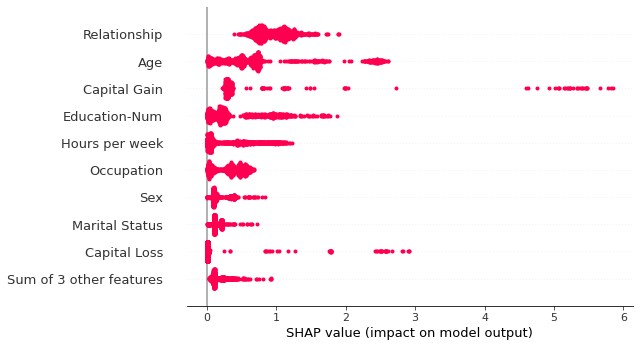

In [26]:
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.beeswarm(explainer.shap_values.abs, color="shap_red", order=order)

Or we  could simplify the visualization of the distribution by using violin plots:

### Linear

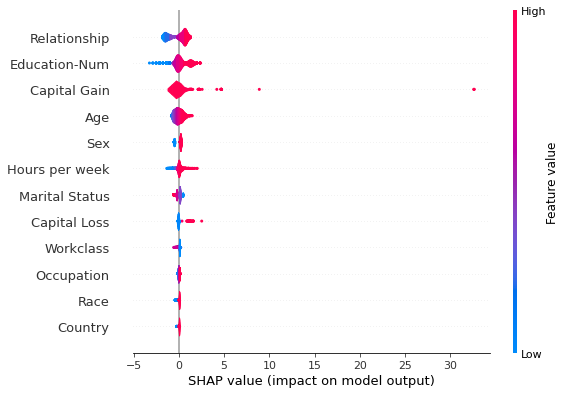

### Tree-based

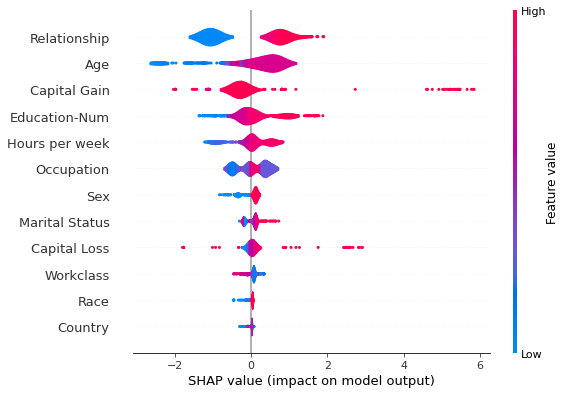

In [27]:
# unfortunately, violin plot has no option to set the order
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.violin(explainer.shap_values.values, features=explainer.shap_values.data, feature_names=feature_names)

## Forceplot

In [28]:
shap.initjs()

In [29]:
last_plot = shap.plots.force(
    base_value=last_explainer.shap_values.abs.mean(0).base_values,
    shap_values=last_explainer.shap_values.values,
    features=last_explainer.shap_values.display_data,
    feature_names=feature_names,
    out_names=last_explainer.identifier)
ordering = list(map(lambda x: int(x['simIndex']), last_plot.data['explanations']))

In [30]:
def force_plot(explainer):
    printmd(f'### {explainer.identifier}')
    return shap.plots.force(
        base_value=explainer.shap_values.abs.mean(0).base_values,
        shap_values=explainer.shap_values.values,
        features=explainer.shap_values.display_data,
        feature_names=feature_names,
        out_names=explainer.identifier,
        ordering_keys=ordering)

In [31]:
force_plot(explainers[0])

### Linear

In [32]:
force_plot(explainers[1])

### Tree-based

## Plot embeddings
Use the SHAP values as an embedding which we project to 2D for visualization, using PCA.

### Linear

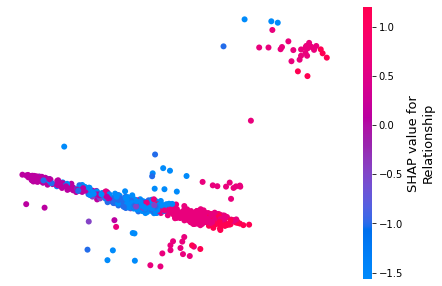

### Tree-based

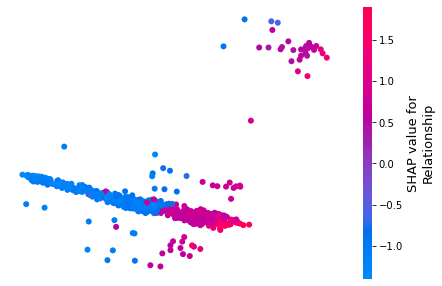

In [33]:
pca = sklearn.decomposition.PCA(2)
embedding_values = pca.fit_transform(last_explainer.shap_values.values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.embedding('Relationship', explainer.shap_values.values, feature_names=feature_names, method=embedding_values)

## Heatmap
Here we use a supervised hierarchical clustering method to visualize the SHAP values

### Linear

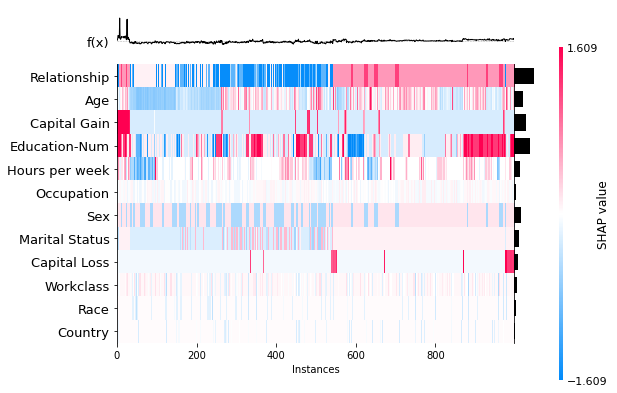

### Tree-based

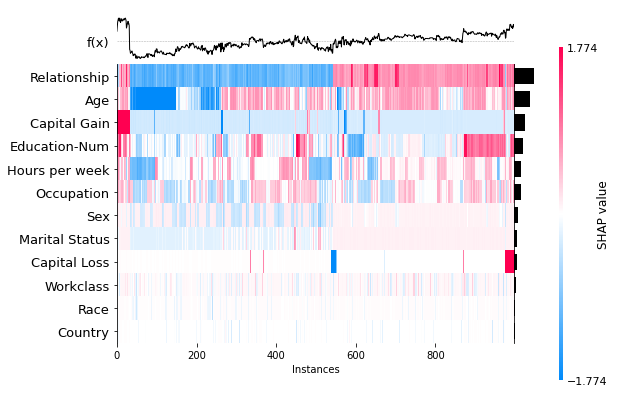

In [34]:
instance_order = last_explainer.shap_values.hclust()
feature_order = np.argsort(-last_explainer.shap_values.abs.mean(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.heatmap(explainer.shap_values, instance_order=instance_order, feature_order=feature_order, max_display=len(feature_names))